# Example: NormalisEd Radon Transform Damage detection, applied to a GeoTIFF image of Pine Island Glacer
2022 - Maaike Izeboud - Delft University of Technology, Department of Geoscience and Remote Sensing

#### About
This notebook provides a step-by-step example of the NormalisEd Radon Transform Damage detection (NeRD) method, as detailed in the publiction "Damage Detection on Antarctic Ice Shelves using the Normalised Radon Transform" by M. Izeboud and S. Lhermitte (2022) in Remote Sensing of Environment (in review, doi: [to be included]).

#### The method
The method consists of the following steps:
1. Configure settings
2. Read image, convert to grayscale
3. Cut image into separate windows of NxN pixels
4. Apply Normalised Radon Transform to each window, yielding a single crevasse signal value ($\sigma_{crev}$) and orientation ($\theta_{crev}$) for every window
5. Calculate damage orientation ($\alpha_c$) and signal ($\hat{D}$)
6. Save output as netCDF and/or geotiff.

Note that:
- Files and parameters should be provided in a configuration file.
- The method is also provided as a python script, which can be run from a local terminal (or cluster) as: 
 `python path/to/main.py path/to/config.ini path/to/image.tiff`

### Packages and Paths

In [1]:

import os
# print(os.getcwd()) # path/to/git/repo/python/notebooks
os.chdir('../../') # go to parent, path/to/git/repo/
this_dir = os.getcwd() 
path_to_modules = os.path.join(this_dir,'python/scripts/')
os.chdir(path_to_modules)

import nerd
import sys
import configparser
import time
import numpy as np
import json
import xarray as xr
from pathos.multiprocessing import ProcessingPool as Pool

import matplotlib.pyplot as plt
import rioxarray as rioxr

xr.set_options(keep_attrs=True)
os.chdir(this_dir)

## 1. Configuration

In [41]:

# -- define config file and image file
configFile = os.path.join(this_dir,'config_files/config_NERD_example.ini')
imageFile = os.path.join(this_dir,'data/example_S2_median_2020-12-1_2021-3-1.tif')
imPath,imName = os.path.split(imageFile) #  split file from path

# -- read config settings
config = configparser.ConfigParser()
config.read(os.path.join(configFile))

path2threshold = config['PATHS']['path2files']
threshold_fname= config['PATHS']['threshold_fname']
img_res = int(config['DATA']['imRes'])
source = config['DATA']['source']
img_min = int(config['DATA']['img_bounds_min'])
img_max = int(config['DATA']['img_bounds_max'])

wsize = int(config['NERD']['window_size_px'])
cores= int(config['NERD']['cores'])
window_range = wsize*img_res

# # NB: for this example, we use a larger window size (than is optimal), for faster processing.
wsize = 50


# -- settings following from config

outPath = os.path.join(imPath,'damage_detection')
if not os.path.isdir(outPath):
    os.mkdir(outPath)

path2save = os.path.join(outPath, 'geotiffs/')
if not os.path.isdir(path2save):
    os.mkdir(path2save)

# define output filename
fname_out = imName[:-4] + '_output_' + str(wsize) + 'px' # [imName_output_Npx]



## 2. Load image, convert to grayscale

In [42]:
# -- read img RGB (for refrence)
img_rgb = rioxr.open_rasterio(os.path.join(imPath , imName))

# -- read img to grayscale
img = nerd.read_img_to_grayscale(imPath, imName, img_min, img_max) # (y,x)

# -- double check img resolution
dx = np.unique(img['x'].diff(dim='x'))
if len(dx) == 1:
    if not dx[0] == img_res:
        raise Exception("Configured img resolution ({}) does not equal grid resolution ({})".format(img_res,dx[0]))
else:
    raise Exception("Inconsistent grid spacing; dx values are {}".format(dx)) 

# -- img is read as xarray DataArray with shape (y,x) 
img

--> clip and normalise img using min,max: [0,255]
..image succesfully converted to grayscale


<xarray.DataArray 'gray_image' (y: 3942, x: 3201)>
array([[0.57393137, 0.57476471, 0.57448196, ..., 0.58850157, 0.59912745,
        0.59689529],
       [0.57951961, 0.58149176, 0.58652941, ..., 0.5893349 , 0.59746078,
        0.59437255],
       [0.58458   , 0.57393137, 0.57785294, ..., 0.60502118, 0.59717804,
        0.59353922],
       ...,
       [0.51710275, 0.48965176, 0.50533804, ..., 0.59435765, 0.58876941,
        0.58876941],
       [0.50643922, 0.49887882, 0.49971216, ..., 0.59435765, 0.58651451,
        0.57867137],
       [0.50308314, 0.50812078, 0.51765333, ..., 0.59464039, 0.58708   ,
        0.5845651 ]])
Coordinates:
  * y        (y) float64 -2.299e+05 -2.299e+05 ... -3.481e+05 -3.481e+05
  * x        (x) float64 -1.648e+06 -1.648e+06 ... -1.552e+06 -1.552e+06
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     grayscale

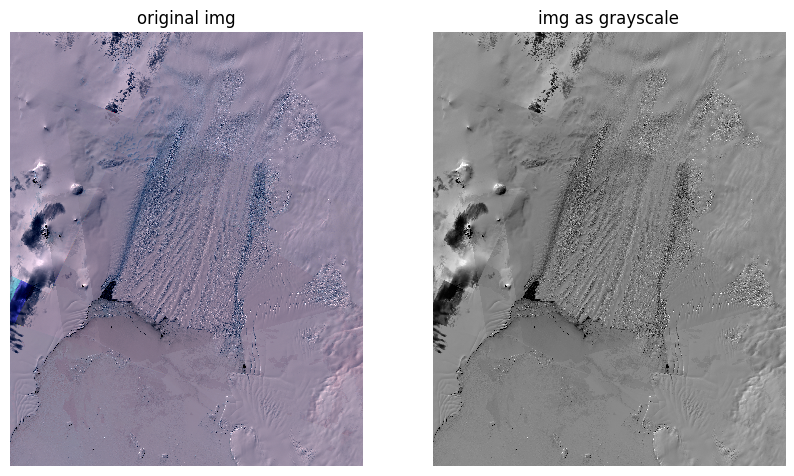

In [15]:
# -- plot data
fig,ax= plt.subplots(1,2,figsize=(10,10)) 
img_rgb.plot.imshow(rgb='band',ax=ax[0] )
img.plot.imshow(ax=ax[1], cmap='gray',vmin=0,vmax=1,add_colorbar=False)
ax[0].set_aspect('equal')
ax[0].set_title('original img');
ax[0].axis('off');
ax[1].set_aspect('equal')
ax[1].set_title('img as grayscale');
ax[1].axis('off');


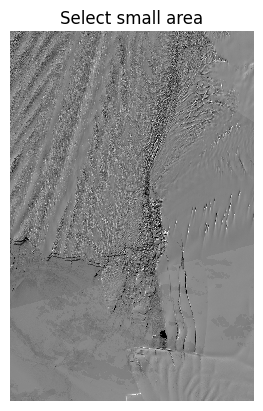

In [43]:
# Subset image for fast processing

## PINE ISLAND ZOOMBOX 
min_lon = -1.605e6 
min_lat = -330e3
max_lon = -1.572e6 
max_lat = -280e3 
clip_bounds = (min_lon, min_lat,max_lon,max_lat)

img.rio.write_crs(3031, inplace=True) # make sure data has correct projection
img_zoom = img.rio.clip_box(*clip_bounds)

ax=plt.axes()
plot_img = img_zoom.plot.imshow(ax=ax,cmap='gray', add_colorbar=False)
ax.set_aspect('equal'); ax.set_title('Select small area')
ax.axis('off');


## 3. Cut image into windows
NB: for this example, we use extremely large windows (100px of 30m resolution --> 3km range per window), so the example can be run relatively fast.
For the actual application of NeRD, we use 10px. 

In [44]:
# -- cut windows

# use full img
# windows_df = nerd.cut_img_to_windows(img,wsize=wsize) # (x_win, y_win, sample)

# use small example area
windows_df = nerd.cut_img_to_windows(img_zoom,wsize=wsize) # (x_win, y_win, sample)

n_window_samples = windows_df.shape[2] ## number of windoows in example area

.. img of (1667, 1100) to (50, 50, 693)


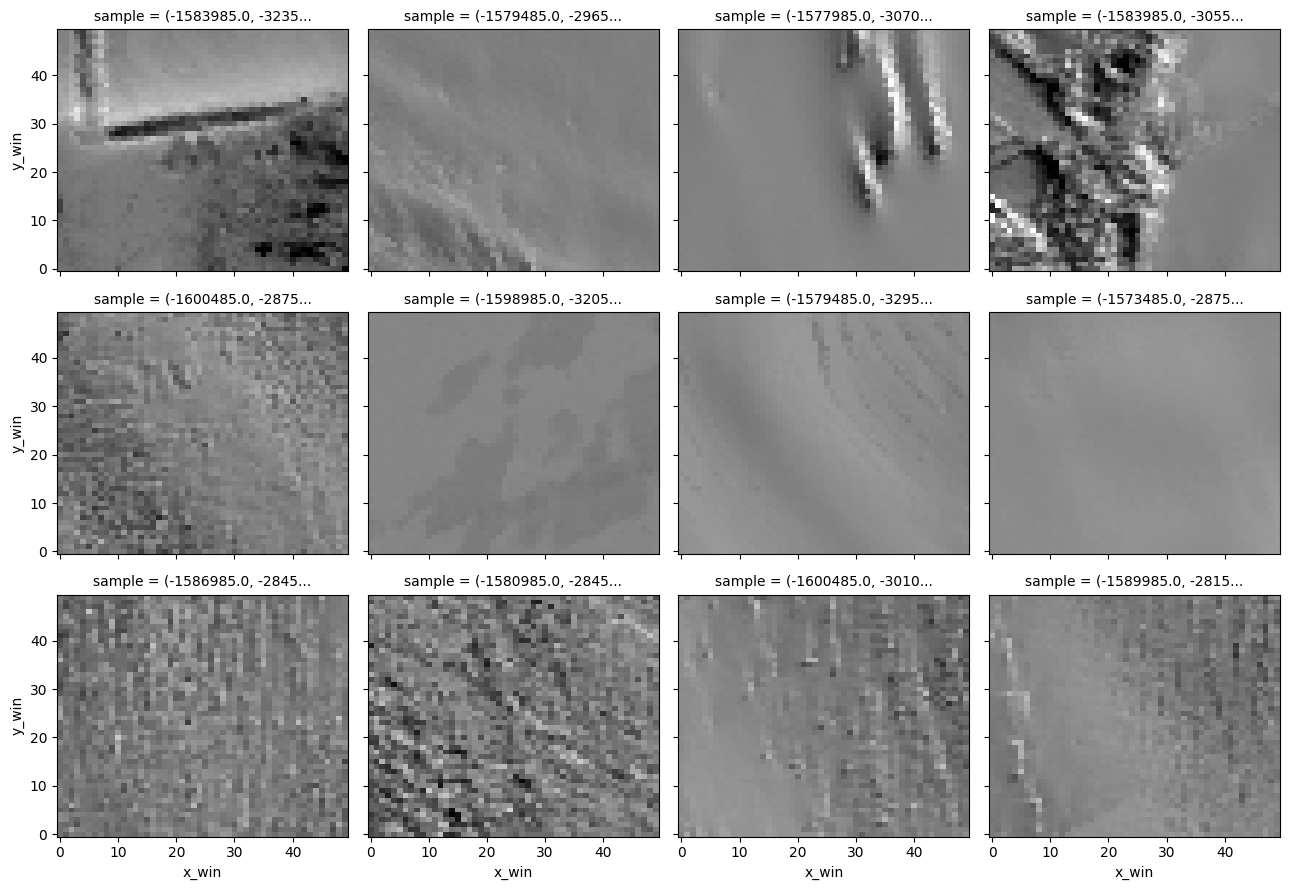

In [45]:
# -- plot a few windows as example

# sample_idx = np.concatenate((np.arange(8400,9000,100),np.arange(10800,11400,100)),axis=0) ## only woorks for windwo-size=10
sample_idx = np.random.randint(0,n_window_samples,size=12)

plot_windows = windows_df.isel(sample=sample_idx).plot(
                    x="x_win", y="y_win", col="sample", col_wrap=4,
                    vmin=0, vmax=1, cmap='gray', add_colorbar=False)


## 4. Process all windows: apply Normalised Radon Transform
Each window is processed in the following steps:
* Increase number of pixels in window by subsampling (linear)
* Rotate the window in steps of $\theta=1^\circ$ untill 180 degrees
* Calculate the normalised linear integral for every rotated projection axis: $R_{norm}(\rho,\theta)$
* This returns a 2D feature space of size (180,M), where M is equal to the window diagonal 

From the 2D freature space, the crevasse signal and orientation is extracted:
* Calculate the standard deviation for every angle: $\sigma(\theta)$
* Calculate max($\sigma(\theta)$) and for which $\theta$ this occurs
* This returns high signal values for the window-rotation that aligns to a linear features within the window. Low values are returned for randomly organised windows.



In [46]:

''' -------
MultiProcess NeRD method with Multi Processing
-----------'''

start_time = time.time()

# split data in parts (equal to N cores) --> converts to list
windows_split = np.array_split(windows_df, cores, axis=2) 
print( 'Split img windows into {} parts of {} windows for multi-processing '.format(cores, [part.shape[2] for part in windows_split] ) )

# Map function over each split data-part, and stack the parts back together
with Pool(cores) as pool: # create the multiprocessing pool 
    print('started pool.map on df_split')
    pool_out = pool.map( nerd.process_img_windows, windows_split) # list of arrays with shape (n_samples_split,8)
    df_out = np.concatenate( pool_out ) # array of shape (samples,8)


pool.close()
pool.join()
pool.clear()    


print('.. done with pool.map after: {:.2f}hour'.format((time.time() - start_time)/(60*60)) )

Split img windows into 5 parts of [139, 139, 139, 138, 138] windows for multi-processing 
started pool.map on df_split
.. done with pool.map after: 0.07hour


In [ ]:

''' -------
Assemble results back to data array 
-----------'''

results = df_out[:,0:2] # array with (samples,2)

# put back to xarray dataArray to convert back to 2D

da_result = xr.DataArray(results,
                            dims=("sample","out"), 
                            coords=(windows_df["sample"], range(2)), 
                            name="output", 
                            attrs=img.attrs, indexes=img.indexes) 

da_result.attrs['long_name'] = 'Output_NeRD'
da_result.attrs['descriptions'] = '[theta_1,signal_1]'


# back to 2D
da_result = da_result.unstack('sample').transpose("y","x","out")

# set attributes that should be saved
da_result.attrs['img_res'] = img_res
da_result.attrs['window_size(px)'] = wsize
da_result.attrs['window_range(m)'] = window_range
da_result.attrs['crs'] = 'EPSG:3031'

da_result


<xarray.DataArray 'output' (y: 166, x: 109, out: 2)>
array([[[1.44000000e+02, 3.70236697e-02],
        [1.29000000e+02, 3.36880119e-02],
        [1.13000000e+02, 5.25370853e-02],
        ...,
        [1.44000000e+02, 1.76652287e-03],
        [1.27000000e+02, 2.78594637e-03],
        [4.90000000e+01, 2.72087522e-03]],

       [[1.10000000e+02, 4.94497100e-02],
        [1.30000000e+02, 4.74274514e-02],
        [1.25000000e+02, 5.92089588e-02],
        ...,
        [5.40000000e+01, 2.02402431e-03],
        [3.50000000e+01, 1.90908377e-03],
        [5.40000000e+01, 2.01008872e-03]],

       [[1.20000000e+02, 2.50713265e-02],
        [1.18000000e+02, 6.40412019e-02],
        [1.23000000e+02, 7.49064459e-02],
        ...,
...
        ...,
        [2.00000000e+01, 8.34541915e-03],
        [1.19000000e+02, 7.07192385e-03],
        [1.03000000e+02, 4.59165480e-03]],

       [[6.90000000e+01, 1.35818922e-02],
        [1.08000000e+02, 1.40692369e-02],
        [7.10000000e+01, 1.38077665e-02],
        ...,
        [1.20000000e+01, 4.44218389e-03],
        [1.25000000e+02, 4.38305813e-03],
        [5.80000000e+01, 3.83602603e-03]],

       [[4.00000000e+00, 1.82223244e-02],
        [8.50000000e+01, 2.52514978e-02],
        [1.25000000e+02, 1.46408580e-02],
        ...,
        [8.50000000e+01, 6.09992774e-03],
        [5.40000000e+01, 6.56448792e-03],
        [5.40000000e+01, 5.17554400e-03]]])
Coordinates:
  * out      (out) int64 0 1
  * x        (x) float64 -1.605e+06 -1.604e+06 ... -1.573e+06 -1.572e+06
  * y        (y) float64 -2.803e+05 -2.806e+05 ... -3.295e+05 -3.298e+05
Attributes:
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        Output_NeRD
    descriptions:     [theta_1,signal_1]
    img_res:          30
    window_size(px):  10
    window_range(m):  300
    crs:              EPSG:3031

## 5. Calculate damage orientation ($\alpha_c$) and signal ($\hat{D}$)

#### Calculate alpha_c from theta_c
$\alpha_c = \theta_{crev} - 90$, such that $\alpha_c$ is [-90 to 90] wrt image horizontal

#### Calculate $\hat{D}$ from $\sigma_{crev}$ by removing noise
$\hat{D} = \sigma_{crev} - \tau_{crev}$ 
With $\tau_{crev}$ the noise threshold. This is a function of the source (Sentinel 2), image pixel resolution (30m) and processed window size (10 pixels)

In [ ]:
# theta_crev to alpha_c
alpha_c = da_result.isel(out=0) - 90 

# convert crevSig to dmg
crevSig = da_result.isel(out=1)
dmg, threshold = nerd.crevsig_to_dmg(crevSig,  os.path.join(path2threshold,threshold_fname), source, img_res,wsize)
dmg = dmg.where(dmg>0) # mask values that are below threshold



.. Loaded  threshold 0.04 --> calculate dmg


## 6. Save data

In [ ]:


''' -------
Save output to netCDF
-----------'''
da_result.to_netcdf(os.path.join(outPath,fname_out+'.nc'))


''' -------
Save to geotiffs
-----------'''

# -- file names for geotiffs per variable

fname_crevSig = fname_out + '_crevSig'
fname_alpha_c = fname_out + '_alphaC'
fname_dmg = fname_out + '_dmg'

# -- export a single band to Cloud Optimzed geotiff

alpha_c.rio.to_raster( os.path.join(path2save, fname_alpha_c + '.tif'),driver="COG")
crevSig.rio.to_raster( os.path.join(path2save, fname_crevSig + '.tif'),driver="COG")
dmg.rio.to_raster( os.path.join(path2save, fname_dmg + '.tif'),driver="COG") 




## Plot data

In [ ]:
# make colormap
# load roma
from matplotlib.colors import LinearSegmentedColormap      
os.chdir(os.path.join(this_dir,'files'))
import romaO
os.chdir(this_dir)

cm_data = romaO.cm_data 

roma_2x= np.concatenate((cm_data,np.flip(cm_data,axis=0)))
# roma_4x= np.concatenate((roma_2x, np.flip(roma_2x,axis=0)))
cm_data=roma_2x

roma_map = LinearSegmentedColormap.from_list('roma', cm_data)    

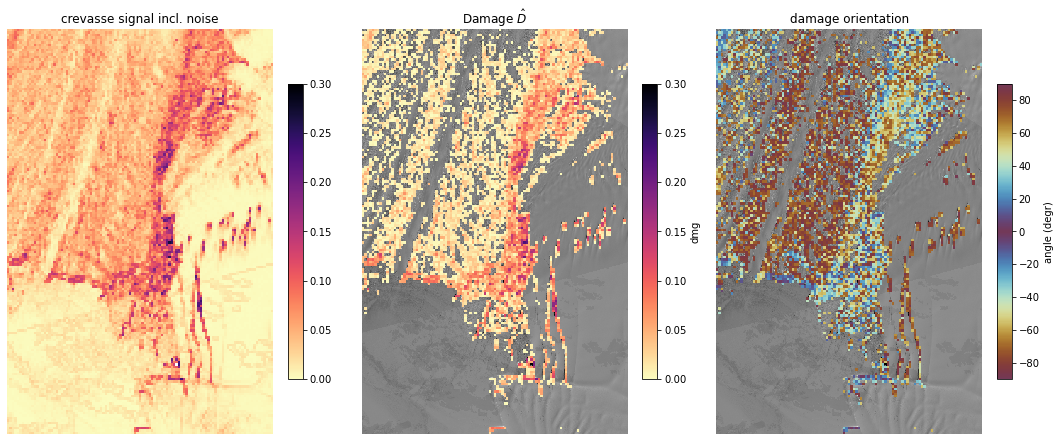

In [ ]:
# plot results

fig,ax=plt.subplots(1,3,figsize=(18,10))

crevSig.plot.imshow(ax=ax[0],cbar_kwargs={'fraction':0.05,'label':''},cmap='magma_r',vmin=0,vmax=0.3)
img_zoom.plot.imshow(ax=ax[1],cmap='gray',add_colorbar=False)
dmg.plot.imshow(ax=ax[1],cbar_kwargs={'fraction':0.05,'label':'dmg'},cmap='magma_r',vmin=0,vmax=0.3)
ax[0].set_title('crevasse signal incl. noise')
ax[1].set_title('Damage $\hat{D}$')

img_zoom.plot.imshow(ax=ax[2],cmap='gray',add_colorbar=False)
alpha_c.where(dmg>0).plot.imshow(ax=ax[2],cmap=roma_map,vmin=-90,vmax=90,cbar_kwargs={'fraction':0.05,'label':'angle (degr)'})
ax[2].set_title('damage orientation');


ax[0].set_axis_off(); ax[1].axis('off'); ax[2].axis('off')
ax[0].set_aspect('equal'); ax[1].set_aspect('equal'); ax[2].set_aspect('equal')




### quiver plot for damage angles

In [ ]:

def plot_angle_and_quiver(img,alpha,dmg,ftitle='',clipBounds=None,scale=0.4,width=100,headwidth=4,figsize=(8,8)):
  
    # angle = alpha.where(dmg.values!=0)# degreess
    angle=alpha
     
    if clipBounds is not None:
        angle = angle.rio.clip_box(*clipBounds) 
        dmg = dmg.rio.clip_box(*clipBounds) 
        img = img.rio.clip_box(*clipBounds) 
        
    
    x = angle['x']
    y = angle['y']   
    
    arrow_length = 300+dmg*3000
    
    u = arrow_length * np.cos(np.deg2rad(angle.values) )
    v = arrow_length * np.sin(np.deg2rad(angle.values) )
    
    fig,axs=plt.subplots(1,1,figsize=figsize)
    h1 = img.plot.imshow(ax=axs,cmap='gray',cbar_kwargs={"fraction": 0.046})

    axs.quiver(x,y, u,v,
                angles='uv',
                units='x',
                scale=scale, #1.1,#0.8,#0.4,
                scale_units='x', # sclae_unit 'x': unit will be 0.5 xax units -- setting scale=1 means 0.5xaxunit, scale > 1:  means <0.5xaxunit (smaller), scale=0-1: bigger
                width=width, #120,#100, # 0.005 typical starting value
                headwidth=headwidth,#4, # default 3
                pivot='mid',
                # color='hotpink',
               color='orangered',
                 )
    axs.set_aspect('equal')
    axs.set_title(ftitle)
    fig.tight_layout()

    return fig, axs

def aggregate_values(alpha,dmg,ksize=3):
    
    alpha_mask = alpha.where(dmg!=0)

    ## COARSEN alpha_c

    dx=3

    # MEDIAAN OF FILTERED MEDIAN
    alpha_coarsen  = alpha_mask.coarsen(x=ksize,y=ksize,boundary='trim').median() # median for angle
    dmg_coarsen    = dmg.coarsen(x=ksize,y=ksize,boundary='trim').max() # max for dmg
    
    return alpha_coarsen, dmg_coarsen




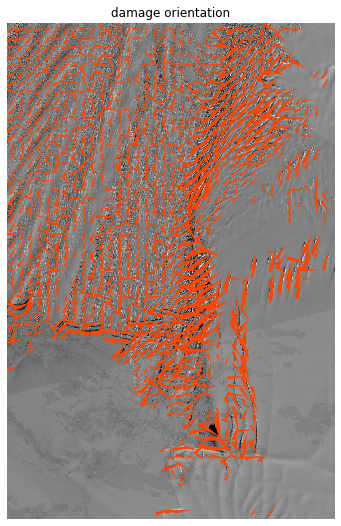

In [ ]:

# set CRS
alpha_c.rio.write_crs(3031, inplace=True)
crevSig.rio.write_crs(3031, inplace=True)
dmg.rio.write_crs(3031, inplace=True)
img.rio.write_crs(3031, inplace=True)

## AGGREGATE ANGLE VALUES (plot fewer quivers than values)

alpha_coarsen, dmg_coarsen = aggregate_values(alpha_c.where(dmg>=0),dmg,ksize=3)

## PLOT QUIVER

scale, width, headwidth= (0.3,350,1) # quiver params 

fig,ax = plot_angle_and_quiver(img, alpha_coarsen, dmg_coarsen,
                        ftitle='damage orientation',clipBounds=clip_bounds,
                        scale=scale,width=width,headwidth=headwidth,figsize=(8,8) )


ax.set_xlim([min_lon,max_lon])
ax.set_ylim([min_lat,max_lat])

a = ax.images[-1]
cb = a.colorbar  
cb.remove()
ax.set_aspect('equal')
ax.set_axis_off()